In [1]:
import sqlite3
import numpy as np
import pandas as pd
import tensorflow as tf

from glob import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt

tf.random.set_seed(9527)

In [2]:
#-- Loading: Training Dataset.

fids = glob('./weather_data/*csv'); fids.sort()
df = pd.DataFrame()
#-- Selected Columns.
#-- The reason why the training dataset only select the vars below is because
#--     1. They are common vars happened in the dataset among years
#--     2. But elimite the 'EVAP' because the numbers of nan value is varied. 
jointCols=['Lat', 'Lon', 'AWND', 'PRCP', 'SNOW', 'SNWD', 
           'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WESD', 'WT01', 'WT02', 
           'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT11', 'date']
for fid in fids:
    year = fid.split('/')[2].split('_')[0]
    if int(year) >= 1992 and int(year) <=2015:
        dd = pd.read_csv(fid,header=0)
        dd['date'] = pd.to_datetime(year+ dd.month.astype('str'), format='%Y%m')  
        df = df.append(dd[jointCols])

df = df.set_index('date')
df.index = df.index.strftime('%Y-%m')        

In [3]:
#-- Loading: Target Dataset.
conn = sqlite3.connect('./FPA_FOD_20170508.sqlite')
query = "SELECT * From Fires"
target= pd.read_sql_query(query, conn)

In [4]:
target = target[target['STATE'] == 'CA']
target = target[['DISCOVERY_DOY',
                 'DISCOVERY_DATE',
                 'LATITUDE',
                 'LONGITUDE',
                 'FIRE_YEAR',
                 'FIRE_SIZE_CLASS',
                 'STAT_CAUSE_DESCR']].drop_duplicates().dropna()
target = target.rename(columns={'DISCOVERY_DATE': 'DISCOVERY_DATE_julian'})
target['DISCOVERY_DATE'] = pd.to_datetime(target['DISCOVERY_DATE_julian'] - pd.Timestamp(0).to_julian_date(), unit='D')
target = target.groupby([pd.Grouper(key='DISCOVERY_DATE', freq='1M'),pd.Grouper(key='FIRE_SIZE_CLASS')]).size().unstack(level=1).fillna(0)
target.index = target.index.strftime('%Y-%m')    
target = target.loc['1992-01':'2015-12']

In [5]:
#-- Train/Target : np.array()
train = [ df.loc[date].values for date in np.unique(df.index.values)]    
x_train, x_test, y_train, y_test = train_test_split(train, target.values, test_size=0.3, random_state=42)

In [6]:
#--- Hidden Layer's Node by Empirical calculation.
print('Empirical Nodes: [{:f}, {:f}]'.format(np.sqrt(20*7), np.sqrt(2*(7+1)*201)))

Empirical Nodes: [11.832160, 56.709788]


---
---
**MLP/Shallow Model**  The reason use shallow model is because the data is small. Avoid overfit

In [7]:
def shallowmodel():
    model = keras.Sequential()
    model.add(preprocessing.Normalization(input_shape=[4410,20,1]))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))    
    model.add(layers.Dense(32))
    model.add(layers.Dense(7))
    return model

In [8]:
model3 = shallowmodel()
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4410, 20, 1)       3         
_________________________________________________________________
flatten (Flatten)            (None, 88200)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5644864   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                5

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


model3.compile(optimizer='rmsprop',loss='mse',metrics=['mae','mse'])
history = model3.fit(np.expand_dims(x_train,axis=-1), np.array(y_train), epochs=1000, validation_split=0.2, verbose=2, callbacks=[early_stop])

Epoch 1/1000
5/5 - 2s - loss: 7295697.0000 - mae: 1684.4026 - mse: 7295697.0000 - val_loss: 589625.3750 - val_mae: 489.9117 - val_mse: 589625.3750
Epoch 2/1000
5/5 - 0s - loss: 435662.9375 - mae: 379.9826 - mse: 435662.9375 - val_loss: 112312.5391 - val_mae: 221.3974 - val_mse: 112312.5391
Epoch 3/1000
5/5 - 0s - loss: 109503.2969 - mae: 206.1152 - mse: 109503.2969 - val_loss: 81820.6172 - val_mae: 185.3043 - val_mse: 81820.6172
Epoch 4/1000
5/5 - 0s - loss: 75341.5781 - mae: 176.8573 - mse: 75341.5781 - val_loss: 72355.3516 - val_mae: 167.5514 - val_mse: 72355.3516
Epoch 5/1000
5/5 - 0s - loss: 64239.1875 - mae: 159.9691 - mse: 64239.1875 - val_loss: 65689.6406 - val_mae: 157.7139 - val_mse: 65689.6406
Epoch 6/1000
5/5 - 0s - loss: 58760.7734 - mae: 155.4377 - mse: 58760.7734 - val_loss: 57093.8945 - val_mae: 143.7809 - val_mse: 57093.8945
Epoch 7/1000
5/5 - 0s - loss: 48576.2734 - mae: 143.0009 - mse: 48576.2734 - val_loss: 67670.4531 - val_mae: 142.0030 - val_mse: 67670.4531
Epoch 8

In [10]:
y_pred = model3.predict(np.expand_dims(x_test,axis=-1))
y_pred[y_pred <0] = 0.
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 34.03612483099519
Mean Squared Error: 4829.877635343511
Root Mean Squared Error: 69.49732106594837


In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
46,9366.540039,54.665783,9366.540039,8076.396973,39.655746,8076.396973,46
47,4835.177734,31.716534,4835.177734,5037.855957,31.010847,5037.855957,47
48,4514.327148,30.068048,4514.327148,6595.041992,42.313076,6595.041992,48
49,6256.857422,38.060802,6256.857422,5391.222168,33.043606,5391.222168,49
50,4414.133789,30.356808,4414.133789,3677.001221,28.686964,3677.001221,50


In [12]:
#-- Set the [numbers of occurance < 0] = 0
y_pred.astype(int)
y_pred[y_pred <0] = 0.
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 34.03612483099519
Mean Squared Error: 4829.877635343511
Root Mean Squared Error: 69.49732106594837


In [13]:
# # 
# df_ytest = pd.DataFrame(y_test, columns=['A','B','C','D','E','F','G'])
# df_ypred = pd.DataFrame(y_pred, columns=['A','B','C','D','E','F','G'])

y_test.shape

(87, 7)

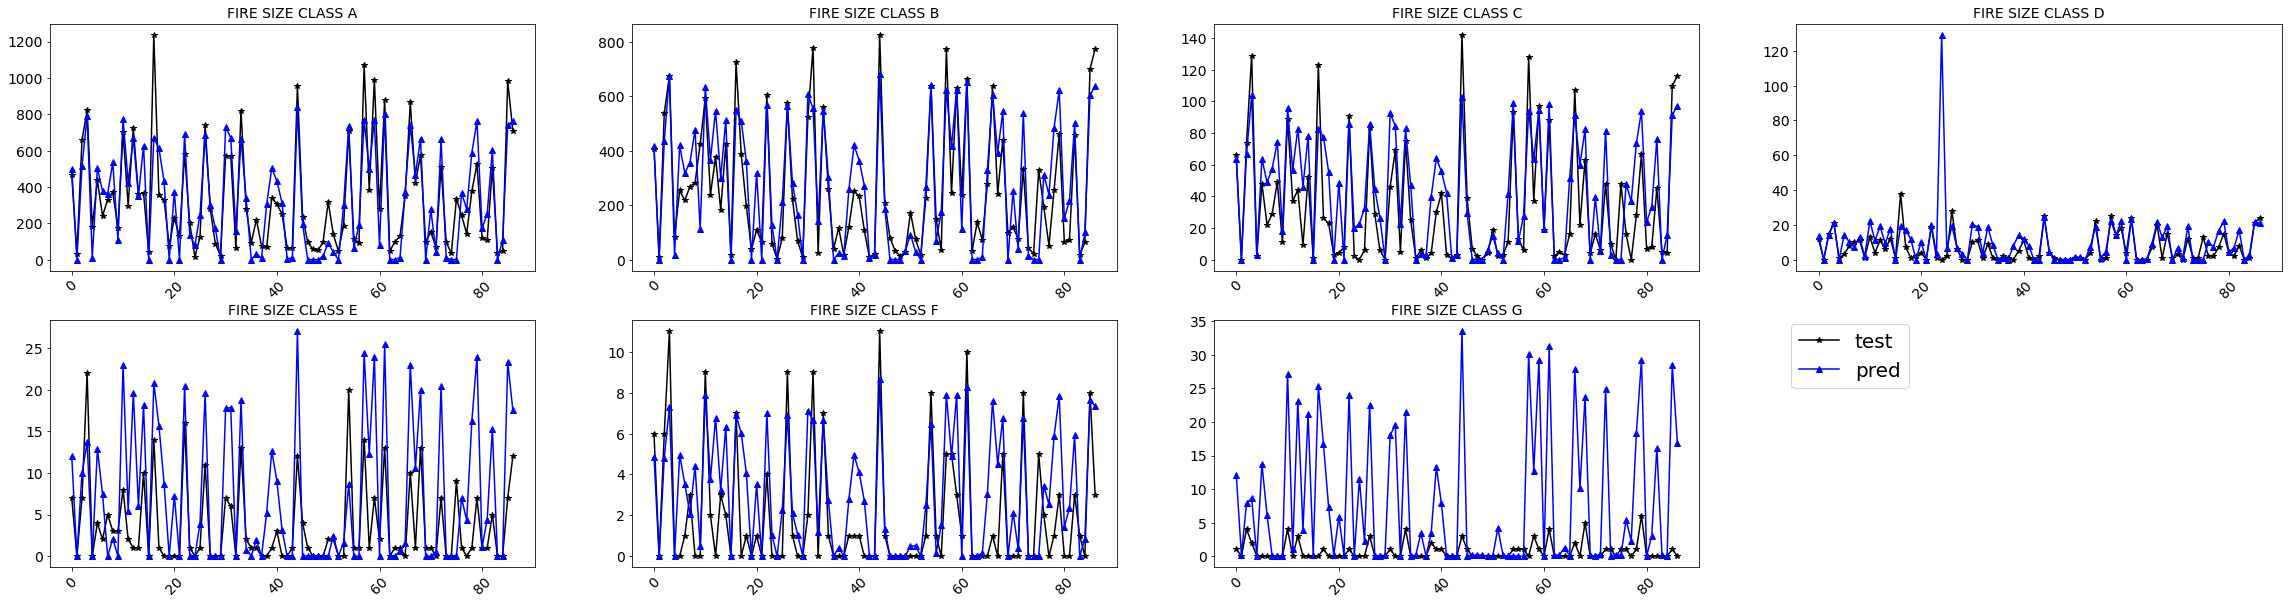

In [14]:
columns=['A','B','C','D','E','F','G']
fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(40,10))
for num, ax in enumerate(axes.flat):
    if num < 7:
        yt,yd = y_test[:,num], y_pred[:,num]
        ax.plot(yt,'k-*')
        ax.plot(yd,'b-^')
        ax.set_title('FIRE SIZE CLASS '+columns[num],fontsize=14)
        ax.tick_params('x', labelrotation=45, labelsize=14)
        ax.tick_params('y',labelsize=14)
    else: ax.axis('off')

fig.legend(['test', 'pred'], loc='lower center', 
           bbox_to_anchor = (0.25,0.36,1,1), 
           bbox_transform = plt.gcf().transFigure,
           fontsize=20,
          )